# 1.2 - Producing the Extended Nakamura & Steinsson (2018) Shock Series (with Daily Data)

This script creates policy shocks for 159 FOMC meetings by taking the first principal component of FOMC meeting day movements in interest rates. Firstly, movements in implied expectations of the Federal Funds Rate between the meeting of interest and the next, and between the next meeting and the one that follows that. These movements are two series, with each date's movements calculated from two of Federal Funds Futures at 1, 2, 3 or 4 months out, depending on what day of the month a meeting takes place. Secondly, movements in Eurodollar Futures at 6, 12 and 24 months out (ED6, ED12 and ED24).

This takes inspiration from Nakamura and Steinsson (2018), who take the first principal component of movements in 30-minute windows surrounding FOMC meetings; they use the same movements in implied expectations of the FFR in addition to ED6, ED9 and ED12 contracts.

A key difference is my usage of daily data to form a 24-hour window around the FOMC meeting, in lieu of access to tick-by-tick data.

All price data are obtained from Bloomberg in *.xlsx* format.

### Preamble

This script makes use of...

- `pandas`
- NumPy (`np`)
- Regular Expressions (`re`)
- `datetime`
- `calendar`
- `PCA` from SciKit Learn

In [92]:
import pandas as pd
import numpy as np
import re
from datetime import datetime
from calendar import monthrange
from sklearn.decomposition import PCA

### Import Meeting Dates

This code imports the meeting dates scraped in script 1.1.

In [93]:
FOMC_dates = []

with open('dates.csv','r') as FOMC_dates_file:
    
    for line in FOMC_dates_file: # The "for" loop is somewhat redundant - the file has only one line.
        
        raw_FOMC_dates = line.split(',')

for date in raw_FOMC_dates:
    
    unix_date = int(re.search("[0-9]+", date).group(0)) # isolates integer from string

    FOMC_dates.append(unix_date)

### Establish Meeting Dates Dataframe - Federal Funds Futures Temporal Data

This block gets all meeting dates into a single dataframe.

It then computes various time data required for proper measurement of the changes in expectations of the Federal Funds Rate, following Nakamura and Steinsson (2018).

The chief issue with identifying shocks to expectations of the Federal Funds rate with Federal Funds Futures is the difference in temporal structure between expectations and the futures contracts themselves.

A Federal Funds Futures contract pays out according to the *average* Federal Funds Rate for the quarter to which it corresponds. Thus, if an FOMC decision occurs on the 16th day of a 31 day month, approximately half the price of the FFF for that month will be made up of the expected or known FFR prior to this date, and approximately half the price will be the expected or known FFR after this date. In theory, if markets expect this meeting to involve no change to the FFR, but the decision is a 0.5% increase, this will be reflected in a 0.25% increase in the rate as reflected by the FFF corresponding to this month. 

What I am concerned with is changes in expectations of the FFR between specific meetings. On any given meeting date, I study surprises to expectations of the FFR between this meeting and the next, and surprises to expectations of the FFR between the next meeting and the one after that. Note that if a meeting occurs in the last week of a month, there is no meeting scheduled for the month that follows. This block of code computes the coefficients required for such adjustments based on the date of the meeting date studied and the meeting date after that.

Let...

- $m_t$ denote the number of days in the current month, $t$.
- $m_{t+1}$ denote the number of days in the month when the next meeting, $t+1$ occurs
- $d_t$ denote the day of the month on which meeting $t$ occurs
- $d_{t+1}$ denote the day of month on which meeting $t+1$ occurs
- $s_1$ denote the current-meeting-day shock to FF1
- $s_2$ denote the current-meeting-day shock to FF2
- $s_n$ denote the current-meeting-day shock to the FFF corresponding to the month in which the next meeting occurs
- $s_{n+1}$ denote the current-meeting-day shock to the FFF corresponding to the month after that in which the next meeting occurs

If meeting $t$ occurs outside the last week of its month, the shock to expectations of the FFR between meeting $t$ and $t + 1$ is given by...

$\phi_{t,t+1} = \frac{m_t}{m_t-d_t}s_1$

If it occurs *during* the last week of its month, the shock to expectations of the FFR between meeting $t$ and $t + 1$ is given by...

$\phi_{t,t+1} = s_2$

If meeting $t+1$ occurs outside the last week of its month, the shock to expectations of the FFR between meeting $t+1$ and $t + 2$ is given by...

$\phi_{t+1,t+2} = \frac{m_{t+1}}{m_{t+1}-d_{t+1}}\left(s_n - \frac{d_{t+1}}{m_{t+1}}\phi_{t,t+1}\right)$

If it occurs *during* the last week of its month, the shock to expectations of the FFR between meeting $t$ and $t + 1$ is given by...

$\phi_{t+1,t+2} = s_{n+1}$

In [94]:
## Get dates into datetime format

dt_dates = [datetime.fromtimestamp(date) for date in FOMC_dates]

movements_df = pd.DataFrame(index = dt_dates)

## Current Meeting: Day of the month

movements_df['day_of_month'] = [int(datetime.strftime(date,'%d')) for date in dt_dates]

## Current Meeting: Days in the month

days_in_month = []

for date in dt_dates:
    
    y = int(datetime.strftime(date,'%Y')) # Get year as number
    
    m = int(datetime.strftime(date,'%m')) # Get month as number
    
    current_month_days = monthrange(y,m)[1] 
    
    days_in_month.append(current_month_days)
    
movements_df['days_in_month'] = days_in_month

## Current Meeting: Is the meeting in the last week of the month?

movements_df['last_7_days'] = [int(x) for x in (movements_df['days_in_month'] - movements_df['day_of_month'] <= 6)]

## Current Meeting: Which futures contract will the shock be measured with?

movements_df['contract'] = ['FF' + str(movements_df.loc[date,"last_7_days"] + 1) for date in dt_dates]

## Current Meeting: What coefficient is required to adjust the futures shock to reflect the shock to FFR expectations?

movement_coef = []

for date in dt_dates:
    
    if movements_df.loc[date,"last_7_days"] == 1: # Since no meeting is scheduled to take place the following month, no adjustment is required and we take the shock to the following month's contract
        
        movement_coef.append(1)
        
    else:
        
        coef = movements_df.loc[date,"days_in_month"]/(movements_df.loc[date,"days_in_month"] - movements_df.loc[date,"day_of_month"])
        
        movement_coef.append(coef)
        
movements_df['movement_coef'] = movement_coef

# Next Meeting: Date

i = 0

next_meeting = [dt_dates[i+1] for i in range(len(dt_dates) - 1)]

next_meeting.append(datetime.fromtimestamp(1390996800)) # The final "next meeting" will not have been pulled from the Fed's website and must be entered manually

movements_df['next'] = next_meeting

## Next Meeting: Day of the month

movements_df['next_day_of_month'] = [int(datetime.strftime(date,'%d')) for date in movements_df['next']]

## Next Meeting: Days in the month

next_days_in_month = []

for date in movements_df['next']:
    
    y = int(datetime.strftime(date,'%Y'))
    
    m = int(datetime.strftime(date,'%m'))
    
    next_month_days = monthrange(y,m)[1]
    
    next_days_in_month.append(next_month_days)

movements_df['next_days_in_month'] = next_days_in_month

## Next Meeting: Is the meeting in the last week of the month?

movements_df['next_last_7_days'] = [int(x) for x in (movements_df['next_days_in_month'] - movements_df['next_day_of_month'] <= 6)]

## Next Meeting: Which futures contract will the shock be measured with?

next_contract = []

for current_date in dt_dates:
    
    next_date = movements_df.loc[current_date,'next']
    
    current_m = int(datetime.strftime(current_date,'%m'))
    
    next_m = int(datetime.strftime(next_date,'%m'))
    
    if current_m < next_m:
        
        months_away = next_m - current_m
    
    elif next_m < current_m:
        
        months_away = next_m + 12 - current_m
    
    else:
        print('Same month error')
    
    contract = 'FF' + str(months_away + movements_df.loc[current_date,'next_last_7_days'] + 1)
    
    next_contract.append(contract)

movements_df['next_contract'] = next_contract

## Current Meeting: What coefficients are required to adjust the futures shock to reflect the shock to FFR expectations?

next_movement_coef_1 = []

next_movement_coef_2 = [] # This multiplies the (adjusted) current meeting shock, to be subtracted from the unadjusted next meeting shock

for date in dt_dates:
    
    if movements_df.loc[date,'next_last_7_days'] == 1: # Since no meeting is scheduled to take place the following month, no adjustments are required and we take the shock to the following  month's contract
        
        next_movement_coef_1.append(1)                 
        
        next_movement_coef_2.append(0)
    
    else:
        
        coef_1 = movements_df.loc[date,"next_days_in_month"]/(movements_df.loc[date,"next_days_in_month"] - movements_df.loc[date,"next_day_of_month"])
        
        next_movement_coef_1.append(coef_1)
        
        coef_2 = movements_df.loc[date,"next_day_of_month"]/movements_df.loc[date,"next_days_in_month"]
        
        next_movement_coef_2.append(coef_2)
        
movements_df['next_movement_coef_1'] = next_movement_coef_1

movements_df['next_movement_coef_2'] = next_movement_coef_2

### Initialising Interest Rates Dataframe to Pull From

This block gets daily prices from the start of 1994 through to the end of 2013 for each interest rate future into the same dataframe.

In [95]:
ir_df = pd.read_excel('FF1.xlsx').set_index('Date').drop(['Open','High','Low','Open Interest','SMAVG (15)'], axis = 1)

# Bloomberg's FF1 series has a different data structure to all others, so is treated as above.

ir_df = ir_df.rename({'Close':'FF1'}, axis = 1)

def merge_df(df_main, x): # This function gets all data from FF1, FF2, FF3, FF4, ED6, ED12 and ED24 into the same dataframe
    
    print(x + ' added')
    
    df_r = pd.read_excel(x + '.xlsx') # for example, 'FF3.xlsx'
    
    df_r = df_r.set_index('Date').drop(['Open Interest','SMAVG (15)'], axis = 1).rename(columns = {'Last Price':x})
    
    return pd.concat([df_main, df_r], axis=1, join = 'inner')

for ir in ['FF2','FF3','FF4','ED6','ED12','ED24']:
    
    ir_df = merge_df(ir_df, ir)

FF2 added
FF3 added
FF4 added
ED6 added
ED12 added
ED24 added


### Establish if Data Exists for all Meetings

This block establishes whether the requisite data (i.e. day of meeting and day before meeting) is available for all meeting dates. At the time of writing, data is available for all meetings but Wednesday the 12th of November, 1997. Since all meetings take place on trading days, the meeting is (safely, at the time of writing) assumed to have taken place on a day when all futures trade.

In [96]:
previous_day_exists = [] # 1 if exists, 0 if not.

for date in ir_df.index:
    
    if date - pd.DateOffset(1) not in ir_df.index: # Checks day before is in the dataframe.
        
        previous_day_exists.append(0)
    
    elif sum(ir_df.loc[date - pd.DateOffset(1)].isna()) > 0: # This checks for 'NaN' values for day before
        
        previous_day_exists.append(0)
        
    else:
        
        previous_day_exists.append(1)
    
ir_df['previous_day_exists'] = previous_day_exists

for date in movements_df.index: # This loop drops any dates for which requisite data is unavailable from the 'movements' dataframe
        
    if ir_df.loc[date,'previous_day_exists'] == 0:
        
        movements_df = movements_df.drop(index = [date])
        
        print(str(date)[:10] + ' dropped.')

1997-11-12 dropped.


### Calculating Price *Movements*

This block takes the end-of-day prices for the day of and before each meeting and calculates the movement over the window. Since each future is priced at $100 - r$ where $r$ is the interest rate in percentage terms, the requisite adjustment is made to reflect the movement in $r$, not $100 - r$.

In [97]:
for ir in ['FF1','FF2','FF3','FF4','ED6','ED12','ED24']: # Loops through each interest rate.
    
    x = []
    
    for date in movements_df.index:
        
        if date.day == 1 and ir in ['FF1','FF2','FF3']: # Handles movement of price corresponding to month from one contract to another at the start of the month
        
            movement = (100 - ir_df.loc[date,ir]) - (100 - ir_df.loc[date - pd.DateOffset(1),'FF' + str(int(ir[2]) + 1)])
        
            x.append(movement)
        
        else:
            
            movement = (100 - ir_df.loc[date,ir]) - (100 - ir_df.loc[date - pd.DateOffset(1),ir])
        
            x.append(movement)
        
    movements_df[ir] = x

### Getting Adjusted FFR Movements

This block establishes which contract is required to calculate the implied shift in expectations of FFR between the current and next meeting, and the next meeting and the one that follows. It then carries out the calculations by the method stated above, with the coefficients found above.

In [98]:
FFR_t0_t1 = [] 

FFR_t1_t2 = []

for date in movements_df.index:
    
    con_t0 = movements_df.loc[date,'contract'] # Contract for current meeting
    
    coef_t0 = movements_df.loc[date,'movement_coef'] # Coefficient for current meeting
    
    mov_t0 = movements_df.loc[date,con_t0] # Movement for current meeting
    
    adj_t0 = coef_t0*mov_t0 # Implied shift in expectations
    
    FFR_t0_t1.append(adj_t0)
    
    con_t1 = movements_df.loc[date,'next_contract'] # Contract for next meeting
    
    coef_t1a = movements_df.loc[date,'next_movement_coef_1'] # Coefficient for next meeting
    
    coef_t1b = movements_df.loc[date,'next_movement_coef_2'] # Movement for next meeting
    
    mov_t1 = movements_df.loc[date,con_t1]
    
    adj_t1 = coef_t1a*mov_t1 - coef_t1b*adj_t0
    
    FFR_t1_t2.append(adj_t1)
    
movements_df['FFR_t0t1'] = FFR_t0_t1

movements_df['FFR_t1t2'] = FFR_t1_t2

movements_df_adj = movements_df.drop(movements_df.columns[:16], axis = 1) # Drops all but movements in Eurodollar Futures and implied FFR expectations.

### Conducting the Principal Component Analysis

This block conducts the principal component analysis, deriving the raw shock series from the data. Although Z-score standardisation is commonplace for principal component analyses for disparate variables, all variables analysed here are in effect movements in interest rates, and as such values are directly commensurable. Thus, I do not standardise the data.

In [99]:
shock_df = movements_df_adj.copy() # This prevents erroneous PCA if the code is re-run without a kernel restart. Conducting a  PCA on a dataframe to which a previous PCA has been added will incorporate that previous shock series into the new analysis, which observation suggests biases the data away from zero.

pca = PCA(n_components = 1)
    
movements = movements_df_adj.values

shock_df['shock'] = pca.fit_transform(movements)

### Export to *.csv*

In [100]:
shock_df.to_csv('shock.csv')

### Producing Figure 1

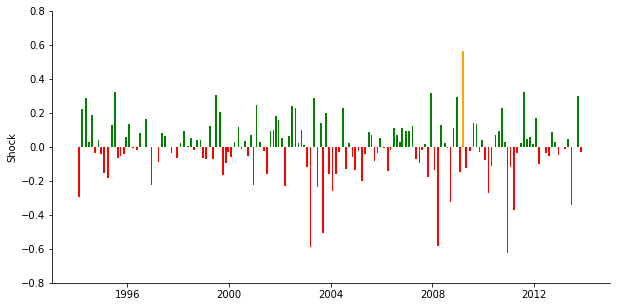

In [101]:
from matplotlib import pyplot as plt

y = -1*shock_df.shock.values

colors = []

x = shock_df.index

QE = [120]

for i in range(len(y)):
    
    if i in QE:
        
        colors.append('orange')
    
    elif y[i] > 0:
        
        colors.append('g')
    
    else:
        
        colors.append('r')

fig = plt.figure(figsize = (10,5))

plt.bar(x,y, width = 25, color = colors)

plt.ylabel('Shock')

plt.ylim([-0.8,0.8])

plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)